In [48]:
import pandas as pd
import codecs
import re
from math import log
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import seaborn as sns
from joblib import dump
from collections import Counter
import collections
import pickle
import itertools

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

AttributeError: type object 'h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'

###  Preproccessing
Load in our datasets and perform some pre-processing, including removing duplicates, merging spam and non-spam datasets once converted to pandas dataframes, and the data is shuffled. Then a train-test-split is performed giving 70% training, and a 30% test 

In [18]:
#load in the data and transform into a oandas dataset and define the columns for the non-spam(ham) file
pathHam = 'C:\\Users\\ciaran\\Downloads\\ham\\*.txt'
fileListHam = glob.glob(pathHam)
list_Ham = []

for fileHam in fileListHam:
    with open(fileHam) as file:
        list_Ham.append(file.read())
        
ham=pd.DataFrame(list_Ham, columns=["emails"])
ham["target"]=0

In [19]:
##check for duplicates and drop if necessary, keep laast so it doesn't auto remove last row
ham.drop_duplicates(keep="last")

,emails,target
0,Subject: christmas tree farm pictures\n,0
1,"Subject: vastar resources , inc .\ngary , prod...",0
3,Subject: re : issue\nfyi - see note below - al...,0
4,Subject: meter 7268 nov allocation\nfyi .\n- -...,0
5,"Subject: mcmullen gas for 11 / 99\njackie ,\ns...",0
...,...,...
3667,Subject: re : tenaska iv\ni ' ll call you on t...,0
3668,"Subject: generic contract\nhi daren ,\nsorry f...",0
3669,Subject: re : contracts and credit\nthanks - -...,0
3670,"Subject: re : tenaska iv\nok , since we don ' ...",0


In [20]:
ham.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   emails  3672 non-null   object
 1   target  3672 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.5+ KB


In [21]:
#view ham dataset top 5 to chack data is looking okay
ham.head()

,emails,target
0,Subject: christmas tree farm pictures\n,0
1,"Subject: vastar resources , inc .\ngary , prod...",0
2,Subject: calpine daily gas nomination\n- calpi...,0
3,Subject: re : issue\nfyi - see note below - al...,0
4,Subject: meter 7268 nov allocation\nfyi .\n- -...,0


In [55]:
##load in the data and transform into a oandas dataset and define the columns for the spam file
pathSpam = 'C:\\Users\\ciaran\\Downloads/spam\\*.txt'
fileListSpam = glob.glob(pathSpam)
list_Spam = []

for fileSpam in fileListSpam:
    with open(fileSpam, encoding="Latin-1") as f:
        list_Spam.append(f.read())
        
spam=pd.DataFrame(list_Spam, columns=["emails"])
spam["target"]=1

In [56]:
#view spam dataset top 5 to chack data is looking okay
spam.head()

,emails,target
0,Subject: dobmeos with hgh my energy level has ...,1
1,Subject: your prescription is ready . . oxwq s...,1
2,Subject: get that new car 8434\npeople nowthe ...,1
3,"Subject: await your response\ndear partner ,\n...",1
4,"Subject: coca cola , mbna america , nascar par...",1


In [57]:
spam.drop_duplicates(keep="last")

,emails,target
0,Subject: dobmeos with hgh my energy level has ...,1
1,Subject: your prescription is ready . . oxwq s...,1
2,Subject: get that new car 8434\npeople nowthe ...,1
3,"Subject: await your response\ndear partner ,\n...",1
4,"Subject: coca cola , mbna america , nascar par...",1
...,...,...
1495,Subject: our pro - forma invoice attached\ndiv...,1
1496,Subject: str _ rndlen ( 2 - 4 ) } { extra _ ti...,1
1497,Subject: check me out !\n61 bb\nhey derm\nbbbb...,1
1498,Subject: hot jobs\nglobal marketing specialtie...,1


In [58]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   emails  1500 non-null   object
 1   target  1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.6+ KB


In [59]:
#combine the spam and ham datasets into one combined dataset using pandas concantenate
emailCom = pd.concat([ham,spam])
# shuffle rows 
emailCom = emailCom.sample(frac=1).reset_index(drop=True)

In [97]:
#chack the combined has both spam and non-spam emails
emailCom

,emails,target
0,"Subject: $ 55486\nhello ,\ni sent you an email...",1
1,Subject: re : fw : fw : 05 / 01 ena gas sales ...,0
2,Subject: ena sales on hpl\njust to update you ...,0
3,Subject: cornhusker - gas management\ni though...,0
4,"Subject: gigavolt\nsparks , ? , online doctors...",1
...,...,...
5167,Subject: 3 / 4 / 2000 and following noms\nthis...,0
5168,Subject: nom change for increased midcon gas ....,0
5169,Subject: re : coastal oil & gas corporation\nm...,0
5170,Subject: fortune most admired ranking\ncongrat...,0


### Train Test Split
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split

In [61]:
#perfrom the train test split 70% train and 30% test, random state for reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(emailCom['emails'],emailCom['target'], train_size= .7, random_state = 862)

In [62]:
Y_train

4165    1
4394    0
1268    0
4769    0
3044    1
       ..
4968    0
3929    0
160     0
3749    1
172     1
Name: target, Length: 3620, dtype: int64

In [63]:
# create a combined dataset of the training data 
training = pd.concat([X_train, Y_train], axis=1)
training.to_csv("training.csv", sep='\t', encoding='utf-8', index=True)

In [64]:
#view combined traing data
training

,emails,target
4165,Subject: select eshopping for medicines and ta...,1
4394,Subject: revised july lst for woodlands\n- - -...,0
1268,"Subject: re : august spot tickets\nvance ,\nde...",0
4769,Subject: deletion of your enrononline user id\...,0
3044,Subject: soldout viagra for only 0 . 78 $ per ...,1
...,...,...
4968,Subject: tenaska iv\nbob :\ni understand from ...,0
3929,Subject: mobil beaumont\nbrian nichols of exxo...,0
160,Subject: hl & p flow\nhere are the most recent...,0
3749,Subject: oem software at cheap prices - fortni...,1


In [65]:
#combined test dataset
testing = pd.concat([X_test,Y_test], axis=1)
testing.to_csv('testing.csv', sep='\t',encoding='utf-8',index=False)

In [66]:
#view data
testing

,emails,target
4707,Subject: re : fuel\nwe need to discuss further...,0
2292,"Subject: we care , no lines ! no hassle ! or e...",1
1929,Subject: your pharmacy nx\nwant a cheap pain k...,1
2697,Subject: volume feedback from unify to sitara\...,0
1080,"Subject: hpl noms for january 6 , 2001\n( see ...",0
...,...,...
133,Subject: adobe 75 % off ! !\ntable align = cen...,1
2601,"Subject: hpl nom for august 10 , 2000\n( see a...",0
3902,Subject: pops production downtime request\nthe...,0
4649,Subject: enron / hpl actuals for february 2 - ...,0


In [67]:
#look for null values
np.where(pd.isnull(emailCom))
#look for empty cells in the email column
np.where(emailCom.applymap(lambda x: x ==""))

(array([], dtype=int64), array([], dtype=int64))

In [68]:
#chaeck data is split correctly
# is 70 percent
X_train.size

3620

In [69]:
X_test.size #is 30 percent

1552

In [70]:
Y_test.mean() # 29% spam, 71% ham

0.3002577319587629

In [71]:
Y_train.head()  #same again

4165    1
4394    0
1268    0
4769    0
3044    1
Name: target, dtype: int64

In [77]:
emailCom.head()

,emails,target
0,"Subject: $ 55486\nhello ,\ni sent you an email...",1
1,Subject: re : fw : fw : 05 / 01 ena gas sales ...,0
2,Subject: ena sales on hpl\njust to update you ...,0
3,Subject: cornhusker - gas management\ni though...,0
4,"Subject: gigavolt\nsparks , ? , online doctors...",1


In [78]:
#isolate the spam emails 
allSpam = ' '.join(training[training['target']==1]['emails'])

https://www.datacamp.com/community/tutorials/wordcloud-python
word cloud source

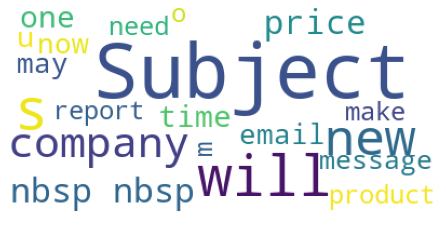

In [79]:
#wordcloud of top 20 spam words pre- stop word implementation
spamfig = WordCloud(max_font_size=70, max_words=20, background_color="white").generate(allSpam)
plt.figure()
plt.imshow(spamfig)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The first step in feature extraction is the use of stop words to allow for removal of frequent words that woulkd be likely to appear in both spam and non-spam emails, this includes words like subject, email style farewells and deashes, etc.
the Lemmatize function is used to change all words to lower case so they aren't counted in their different forms.
Tokenizer is used to split emails into  individual words and emove punctuationn.
These functions are used on both test and train files, and thge test file is retained until the end.
From the sk.learn package TFIDF Bag of words and Bag Of Words. bag of words measures the occurance of words, and Tfidf creates a set of vecotrs containing count of word occurances, and mesures how relevant a word is to the selected email in the collection. this is done by multiplying "times word appears" by "inverse document frequency across the dataset"

In [162]:
#set stop words function, remove words/symbols/stray letters which are common
#displays list of removed words
#waste of space to print but there if necessery, it will be ### out in the report
sw = set(stopwords.words('english'))
newStopWords = (['subject','email','looking','yours','regards','best','-', '_','u','a','e','kind','www','enron','http'])
sws =sw.union(newStopWords)
#print(sws)

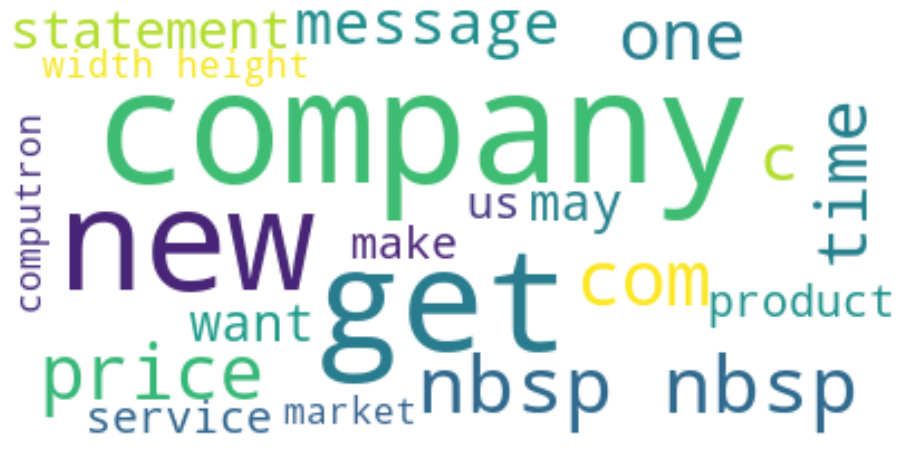

In [163]:
#spam wordcloud with stop words implemented, stopwords= sws
spamfigclean = WordCloud(stopwords=sws, max_font_size = 70,  max_words=20, background_color="white").generate(allSpam)
plt.figure()
plt.imshow(spamfigclean, interpolation='bilinear')
plt.axis('off')
plt.show()

https://www.machinelearningplus.com/nlp/lemmatization-examples-python/ - for lemmatize
https://www.nltk.org/_modules/nltk/tokenize/regexp.html - for Tokenization

In [164]:
#perform on both trian and test
lowerCase= WordNetLemmatizer()
tokentext = RegexpTokenizer(r'\w+')

def lematize(text):
    return [lowerCase.lemmatize(w) for w in tokentext.tokenize(text)]

X_train_lowerCase = X_train.apply(lematize)
X_train_clean = X_train_lowerCase.apply(lambda x: ' '.join([word for word in x if word.lower() not in sws]))

X_test_lowerCase = X_test.apply(lematize)
X_test_clean = X_test_lowerCase.apply(lambda x: ' '.join([word for word in x if word.lower() not in sws]))

In [165]:
#check X_trian_clean afetr processing above
X_train_clean.head()

4165    select eshopping medicine take advantage speci...
4394    revised july lst woodland forwarded ami choksh...
1268    august spot ticket vance deal 348777 ha create...
4769    deletion enrononline user id password deletion...
3044    soldout viagra 0 78 per pill cheap cialis save...
Name: emails, dtype: object

In [166]:
#create another pandas dataset
train_clean = pd.concat([X_train_clean, Y_train],axis=1)
train_clean.columns = ['emails','target']

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

In [167]:
#countVectorizer assigns an identifier to each word
vectorGrp = CountVectorizer(min_df=5, ngram_range=(1,2), analyzer='char_wb')
Xvec_word = vectorGrp.fit_transform(np.array(X_train_clean))
Xvec_word.shape

(3620, 888)

In [168]:
#convert from array to matrix
#rows = number of emails 
#columns= ids mentioned prior
matrixGrp = Xvec_word.toarray()
print(matrixGrp)

[[226   0   0 ...   0   0   0]
 [ 82   4   0 ...   0   0   0]
 [522  10   2 ...   0   0   0]
 ...
 [ 10   0   0 ...   0   0   0]
 [ 70   1   1 ...   0   0   0]
 [ 96   0   1 ...   0   0   0]]


In [169]:
#get the shape of new matrix
matrixGrp.shape

(3620, 888)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [170]:
#tf-idf converts raw data to matrix of equations
#converted to np.array to give shape to the transformed document
transformVec = TfidfVectorizer(min_df=5, ngram_range= (1,2), analyzer= 'char_wb')
XVecTransform = transformVec.fit_transform(X_train_clean)

NN = np.array(transformVec.get_feature_names())
sort_vec = XVecTransform.max(0).toarray()[0].argsort()

C:\Users\ciaran\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [171]:
VecF = XVecTransform.toarray()
print(VecF)

[[0.73882038 0.         0.         ... 0.         0.         0.        ]
 [0.82000766 0.06516686 0.         ... 0.         0.         0.        ]
 [0.82307469 0.02568807 0.00461523 ... 0.         0.         0.        ]
 ...
 [0.70248045 0.         0.         ... 0.         0.         0.        ]
 [0.75669957 0.01761117 0.01582049 ... 0.         0.         0.        ]
 [0.70610036 0.         0.0107644  ... 0.         0.         0.        ]]


In [172]:
train_clean['emails'] = train_clean['emails'].str.findall('\w{4,}').str.join(' ')

In [173]:
train_clean['emails'] = train_clean['emails'].str.replace('\d+', '')

In [174]:
train_clean.head()

,emails,target
4165,select eshopping medicine take advantage speci...,1
4394,revised july woodland forwarded chokshi corp ...,0
1268,august spot ticket vance deal created entered...,0
4769,deletion enrononline user password deletion no...,0
3044,soldout viagra pill cheap cialis save shipped ...,1


In [175]:
len(train_clean)

3620

## Exploratory Data Analysis (EDA)
We look at diiferent aspeact of the cleansed data, including top 20 words pre and post cleaning, a boxplot to see which emails have longer lengths and where the longest email is located

<AxesSubplot:ylabel='Word'>

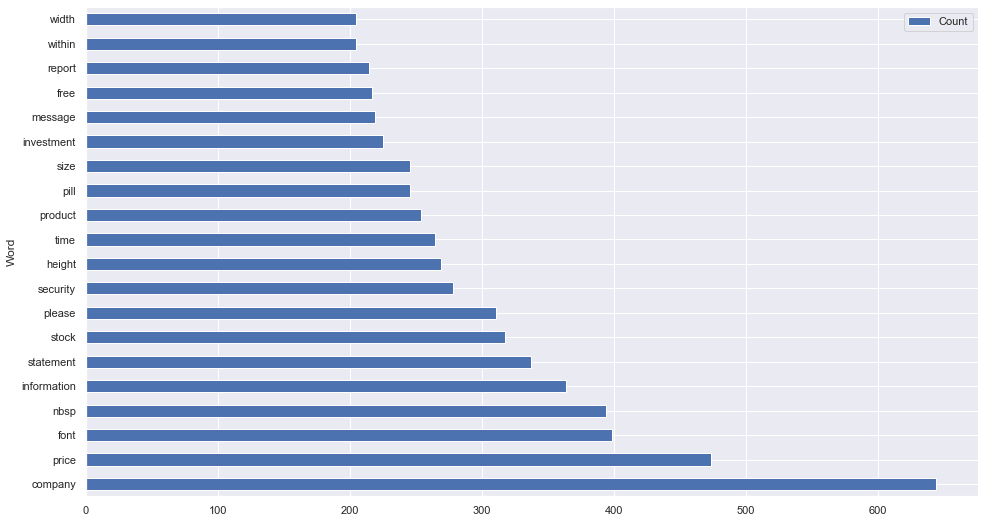

In [176]:
spamTotal = ' '.join(train_clean[train_clean['target']==1]['emails'])
spamT20 = collections.Counter(spamTotal.split()).most_common(20)
spam20=pd.DataFrame(spamT20, columns = ['Word', 'Count'])
plt.xticks
plt.rcParams['figure.figsize'] = 16,9
spam20.plot.barh(x='Word',y='Count')

In [177]:
#top 10 spam words
spam20.head(10)

,Word,Count
0,company,644
1,price,474
2,font,399
3,nbsp,394
4,information,364
5,statement,337
6,stock,318
7,please,311
8,security,278
9,height,269


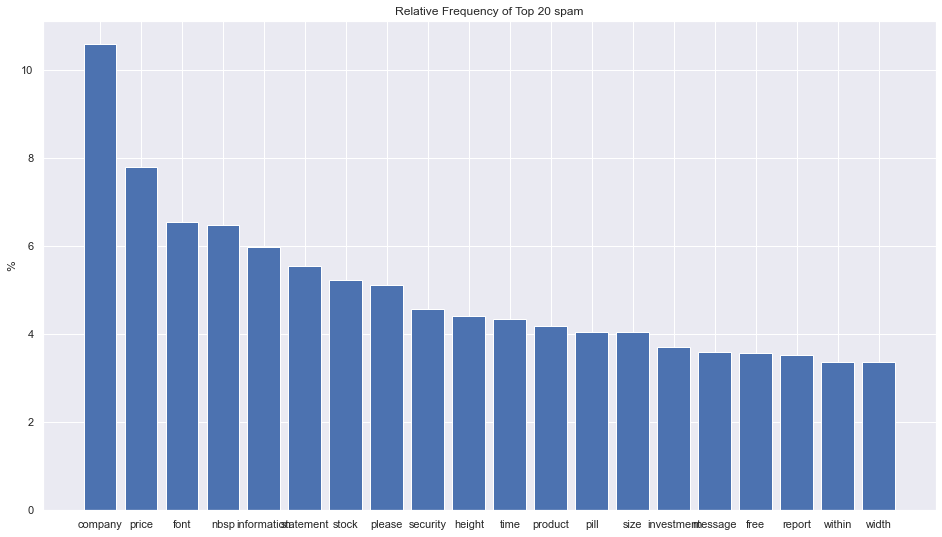

In [178]:
seriesChange = spam20['Count']/sum(spam20['Count'])
indxRng = range(20)
plt.bar(indxRng, seriesChange*100)
plt.ylabel('%')
plt.title('Relative Frequency of Top 20 spam')
plt.xticks(indxRng, spam20['Word'])
figsize=(16,9)

<AxesSubplot:ylabel='Word'>

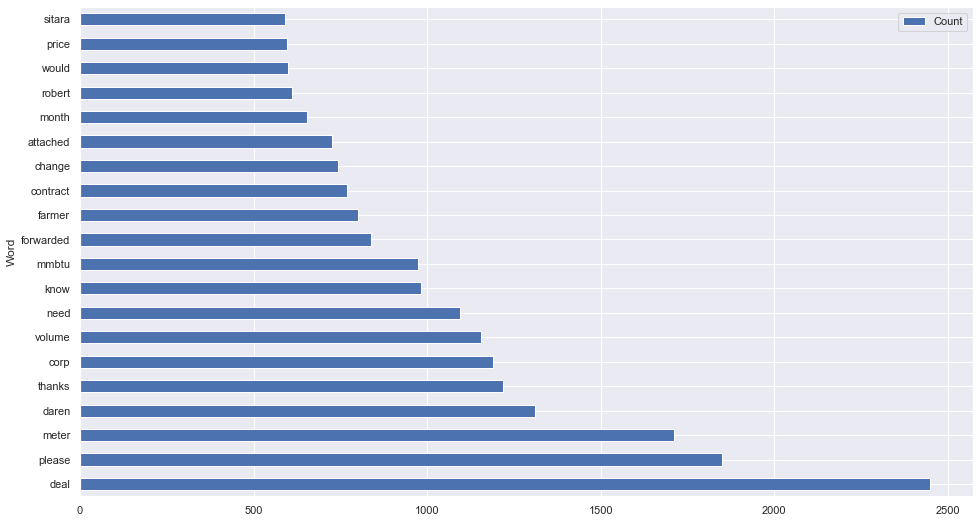

In [179]:
#bar chart of most frequently used words vs word count for non-spam
hamTotal = ' '.join(train_clean[train_clean['target']==0]['emails'])
hamT20 = collections.Counter(hamTotal.split()).most_common(20)
ham20=pd.DataFrame(hamT20, columns = ['Word', 'Count'])
plt.rcParams['figure.figsize'] = 16,9
ham20.plot.barh(x='Word',y='Count')

In [180]:
#view non-spam top 10 words
ham20.head(10)

,Word,Count
0,deal,2449
1,please,1849
2,meter,1710
3,daren,1311
4,thanks,1218
5,corp,1191
6,volume,1154
7,need,1094
8,know,983
9,mmbtu,974


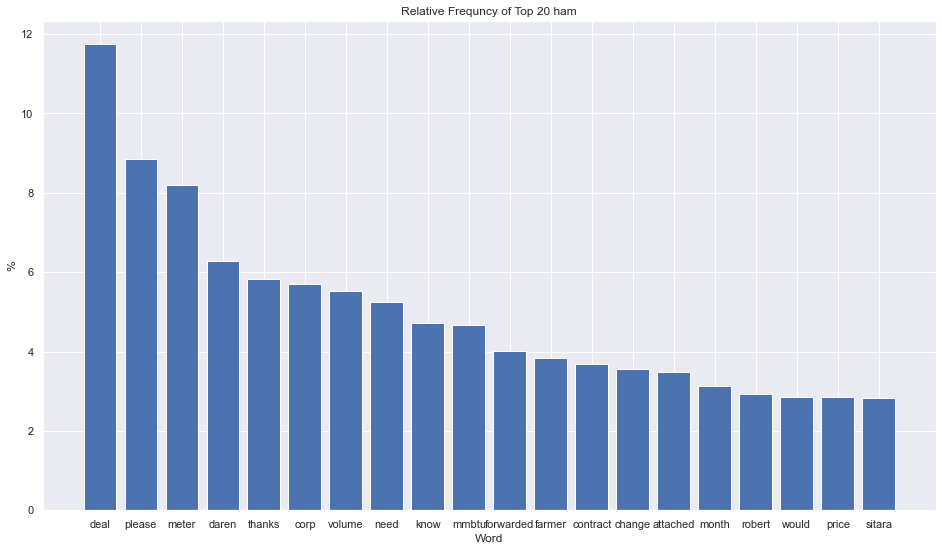

In [181]:
#frequency bar chart of the top 20 non-spam words
seriesChange1 = ham20['Count']/sum(ham20['Count'])
indxRng1 = range(20)
plt.bar(indxRng1, seriesChange1*100)
plt.xlabel("Word")
plt.ylabel('%')
plt.title('Relative Frequncy of Top 20 ham')
plt.xticks(indxRng1,ham20['Word'])
figsize=(16,9)

In [182]:
#add in email length (for visualisation) and class (for convenience)
#will make graphs look better
train_clean['length']=train_clean['emails'].str.len()
terms = [train_clean['target']==1,train_clean['target']==0]
out = ['Spam','NonSpam']
train_clean['Class'] = np.select(terms, out)
train_clean.head()

,emails,target,length,Class
4165,select eshopping medicine take advantage speci...,1,725,Spam
4394,revised july woodland forwarded chokshi corp ...,0,130,NonSpam
1268,august spot ticket vance deal created entered...,0,1090,NonSpam
4769,deletion enrononline user password deletion no...,0,832,NonSpam
3044,soldout viagra pill cheap cialis save shipped ...,1,127,Spam


max length around 21,000 in the spam class
this is a major outlier compared to every other data point in both classes
boxplot of email length separated by class

(0.0, 25000.0)

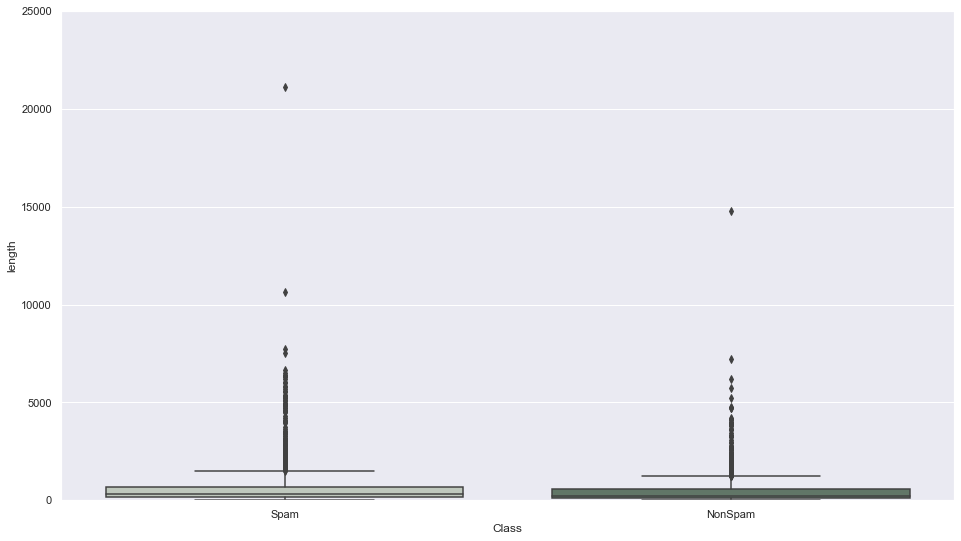

In [183]:
#using seaborn package
sns.set(context='notebook', style='darkgrid')
figsize = (10,10)
boxP = sns.boxplot(x='Class',y='length', palette='Greens', saturation = 0.2, data=train_clean)
boxP.set_ylim([0,25000])

(0.0, 2000.0)

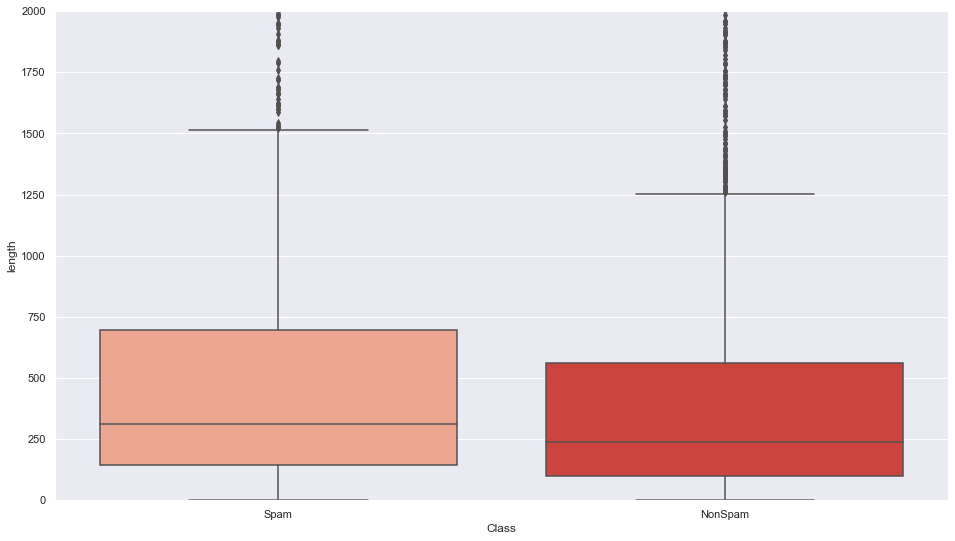

In [184]:
#a close up of the boxplot shown above, spam email has an average longer length
sns.set(context='notebook', style='darkgrid')
figsize = (12,9)
boxP = sns.boxplot(x='Class',y='length', palette= "Reds",data= train_clean)
boxP.set_ylim([0,2000])

In [185]:
#longest email is spam
train_clean[train_clean['length']==train_clean['length'].max()]

,emails,target,length,Class
3698,online pharxmacy disscount phafrmacy onlsine g...,1,21115,Spam


In [187]:
#compute 5 most common words from longest email
long = train_clean.loc[3698,'emails']
collections.Counter(long.split()).most_common(5)

[('dosage', 28),
 ('afloat', 15),
 ('conversion', 15),
 ('respecter', 15),
 ('compendia', 15)]

### Supervised Classification
Here we look at different types of classifications models multinomial naive bayes, logistic regression, and random forest. we will check the accuracy of the f1 score of each model, while applying count vectorizer and tfidf vectorizer to each model separately to fin the model with the highest accuracy.
A validation train test is apploed to the current train_clean dataframe in other to perform a validation on our models.

In [188]:
#create a train test split for the purpose of cross validation 
X_train_2, X_val, Y_train_2, Y_val = train_test_split(train_clean['emails'], train_clean['target'], train_size=.71, random_state=862)

In [189]:
#perform some EDA
#check parameters are correct
X_train_2[1:5]

3478    revised resource daren orig meter  revised wan...
2974      first delivery choice exploration attached file
972     tenaska cleburne march  spreadsheet march than...
78                   january  attached file hplnol hplnol
Name: emails, dtype: object

In [190]:
X_train.describe()

count                                                  3620
unique                                                 3518
top       Subject: calpine daily gas nomination\n>\nrick...
freq                                                     17
Name: emails, dtype: object

In [191]:
X_train_2.describe()

count                                 2570
unique                                2352
top       march  attached file hplno hplno
freq                                    16
Name: emails, dtype: object

In [192]:
X_train_2.size

2570

In [193]:
X_val.describe()

count                                 1050
unique                                1001
top       april  attached file hplno hplno
freq                                     6
Name: emails, dtype: object

In [194]:
Y_train_2.size

2570

In [195]:
Y_val.size

1050

https://www.datacamp.com/community/tutorials/scikit-learn-fake-news

In [196]:
#a function for creating good looking confusion matrices
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [197]:
#the data is now trained as Multinomial bayes model
##multinomial bayes model using count vectorizer
bag_of_w_vec = CountVectorizer().fit(X_train_2)
train2Vec = bag_of_w_vec.transform(X_train_2)
MB_bow = MultinomialNB(alpha=0.1)
MB_bow.fit(train2Vec,Y_train_2)
y_pred = MB_bow.predict(train2Vec)
X_bow_val = bag_of_w_vec.transform(X_val)
y_val_model = MB_bow.predict(X_bow_val)

In [198]:
y_pred.size

2570

In [199]:
y_val_model.size

1050

In [200]:
X_val.size

1050

In [201]:
print(confusion_matrix(Y_val, y_val_model))

[[725   6]
 [ 29 290]]


Confusion matrix, without normalization


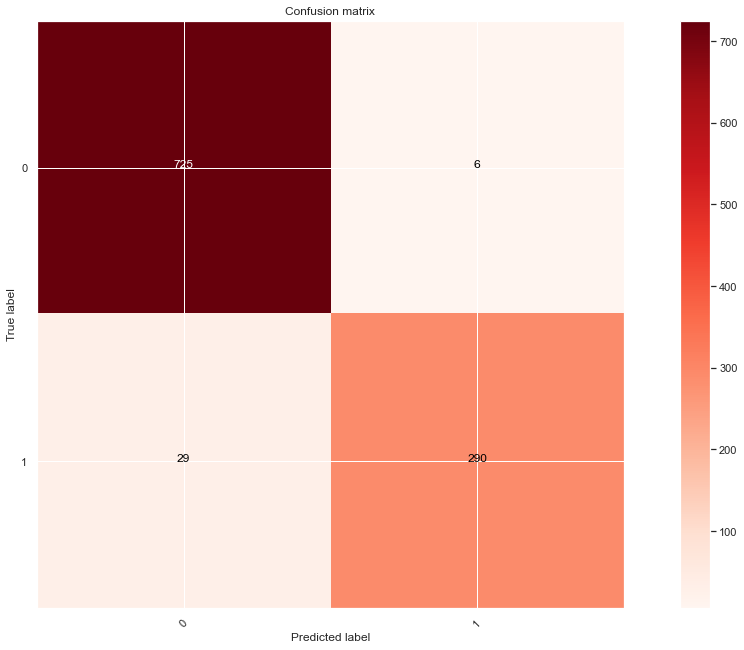

In [202]:
#visualised confusion matrix, the rest will look similar to avove to save on space but this can be 
#applied to each confusion matrix
cm = metrics.confusion_matrix(Y_val, y_val_model, labels=[0,1])
plot_confusion_matrix(cm, classes = [0,1])

In [203]:
#classification reort of MNB using count vectorizer
print(classification_report(Y_val, y_val_model, digits= 4))

              precision    recall  f1-score   support

           0     0.9615    0.9918    0.9764       731
           1     0.9797    0.9091    0.9431       319

    accuracy                         0.9667      1050
   macro avg     0.9706    0.9504    0.9598      1050
weighted avg     0.9671    0.9667    0.9663      1050



In [204]:
pickle.dump(MB_bow, open('MB_count.sav', 'wb'))

In [205]:
#multinomial bayes model using tfidf vectoizer
tf_vector = TfidfVectorizer().fit(X_train_2)
Xtrain_tfidf = tf_vector.transform(X_train_2)
tfBayes = MultinomialNB(alpha=0.1)
tfBayes.fit(Xtrain_tfidf, Y_train_2)
ytrain_tfidf_pred = tfBayes.predict(Xtrain_tfidf)
Xval_tfidf = tf_vector.transform(X_val)
yval_tfidf = tfBayes.predict(Xval_tfidf)

In [206]:
print(confusion_matrix(Y_val, yval_tfidf))

[[726   5]
 [ 32 287]]


In [207]:
#cm = metrics.confusion_matrix(Y_val, yval_tfidf, labels=[0,1])
#plot_confusion_matrix(cm, classes = [0,1])

In [208]:
#classification reort of MNB using tfidf vectorizer
print(classification_report(Y_val, yval_tfidf, digits= 4))

              precision    recall  f1-score   support

           0     0.9578    0.9932    0.9752       731
           1     0.9829    0.8997    0.9394       319

    accuracy                         0.9648      1050
   macro avg     0.9703    0.9464    0.9573      1050
weighted avg     0.9654    0.9648    0.9643      1050



In [71]:
pickle.dump(tfBayes, open('MB_tfidf.sav', 'wb'))

In [210]:
##linear regression model using count vectorizer
lr1 = CountVectorizer().fit(X_train_2)
lr2 = lr1.transform(X_train_2)

lr3 = LogisticRegression()
lr3.fit(lr2, Y_train_2)
lr4 = lr3.predict(lr2)

lr5 = lr1.transform(X_val)
lr6 = lr3.predict(lr5)

In [211]:
print(confusion_matrix(Y_val, lr6))

[[710  21]
 [ 13 306]]


Confusion matrix, without normalization


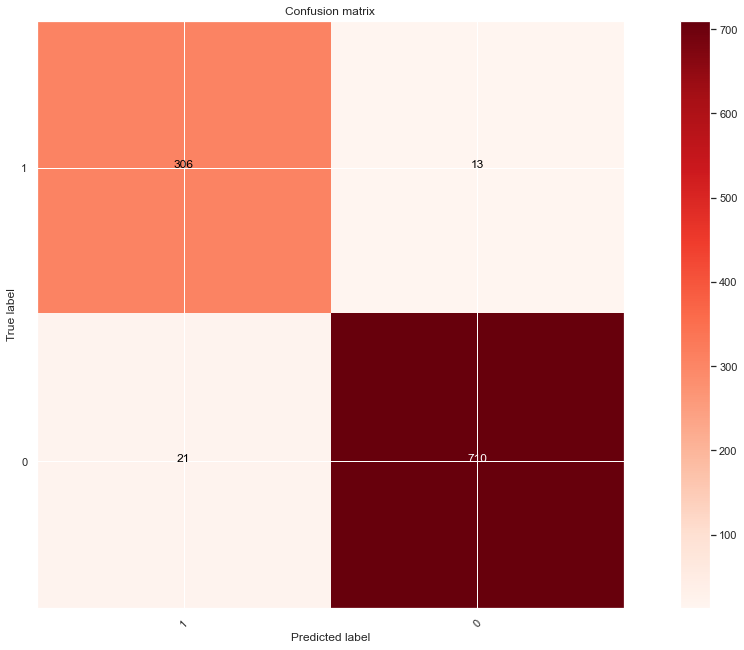

In [212]:
cm = metrics.confusion_matrix(Y_val, lr6, labels=[1,0])
plot_confusion_matrix(cm, classes = [1,0])

In [213]:
#classification reort of LR using count vectorizer
print(classification_report(Y_val, lr6, digits= 4))

              precision    recall  f1-score   support

           0     0.9820    0.9713    0.9766       731
           1     0.9358    0.9592    0.9474       319

    accuracy                         0.9676      1050
   macro avg     0.9589    0.9653    0.9620      1050
weighted avg     0.9680    0.9676    0.9677      1050



In [214]:
pickle.dump(lr3, open('LR_count.sav', 'wb'))

In [215]:
#linear regression model using tfidf vectorizer
lrf1 = TfidfVectorizer().fit(X_train_2)
lrf2 = tf_vector.transform(X_train_2)

lrf3 = LogisticRegression()
lrf3.fit(lrf2, Y_train_2)
lrf4 = lrf3.predict(lrf2)

lrf5 = lrf1.transform(X_val)
lrf6 = lrf3.predict(lrf5)

In [216]:
#classification reort of LR using tfidf vectorizer
print(classification_report(Y_val, lrf6, digits= 4))

              precision    recall  f1-score   support

           0     0.9770    0.9863    0.9816       731
           1     0.9679    0.9467    0.9572       319

    accuracy                         0.9743      1050
   macro avg     0.9725    0.9665    0.9694      1050
weighted avg     0.9742    0.9743    0.9742      1050



Confusion matrix, without normalization


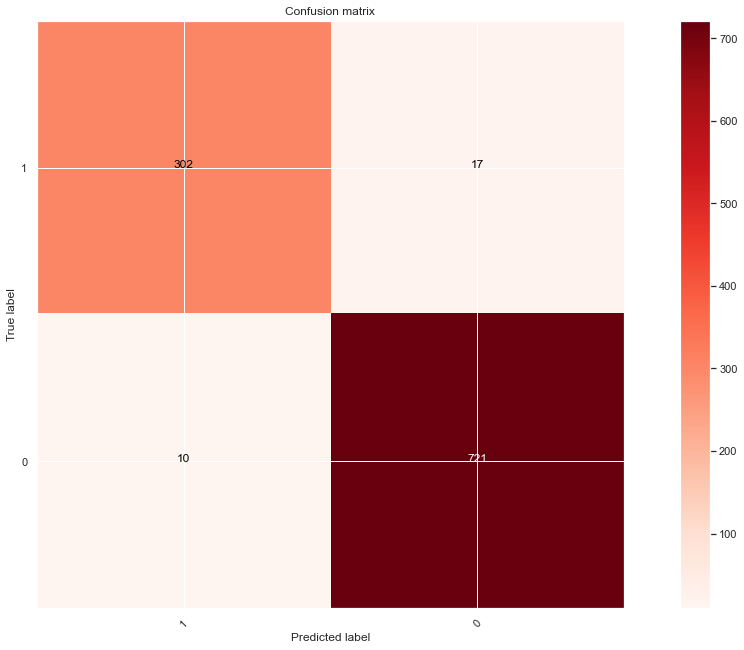

In [217]:
cm = metrics.confusion_matrix(Y_val, lrf6, labels=[1,0])
plot_confusion_matrix(cm, classes = [1,0])

In [218]:
pickle.dump(lrf3, open('LR_tfidf.sav', 'wb'))

In [219]:
#random forest using count vectorizer model
rf1 = CountVectorizer().fit(X_train_2)
rf2 = rf1.transform(X_train_2)

rf3 = RFC()
rf3.fit(rf2, Y_train_2)
rf4 = rf3.predict(rf2)

rf5 = rf1.transform(X_val)
rf6 = rf3.predict(rf5)

In [220]:
#classification reort of RF using count vectorizer
print(classification_report(Y_val, rf6, digits= 4))

              precision    recall  f1-score   support

           0     0.9777    0.9603    0.9689       731
           1     0.9127    0.9498    0.9309       319

    accuracy                         0.9571      1050
   macro avg     0.9452    0.9551    0.9499      1050
weighted avg     0.9579    0.9571    0.9574      1050



Confusion matrix, without normalization


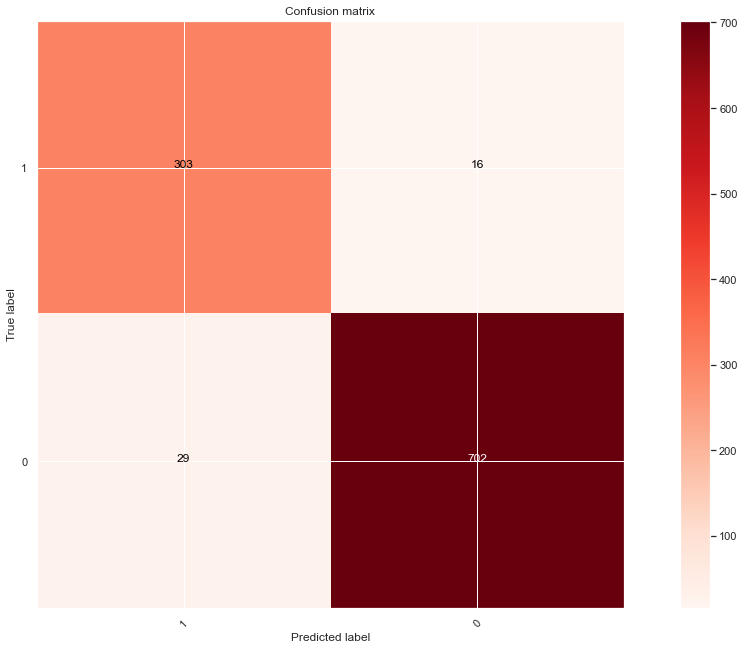

In [221]:
cm = metrics.confusion_matrix(Y_val, rf6, labels=[1,0])
plot_confusion_matrix(cm, classes = [1,0])

In [222]:
pickle.dump(rf3, open('RF_count.sav', 'wb'))

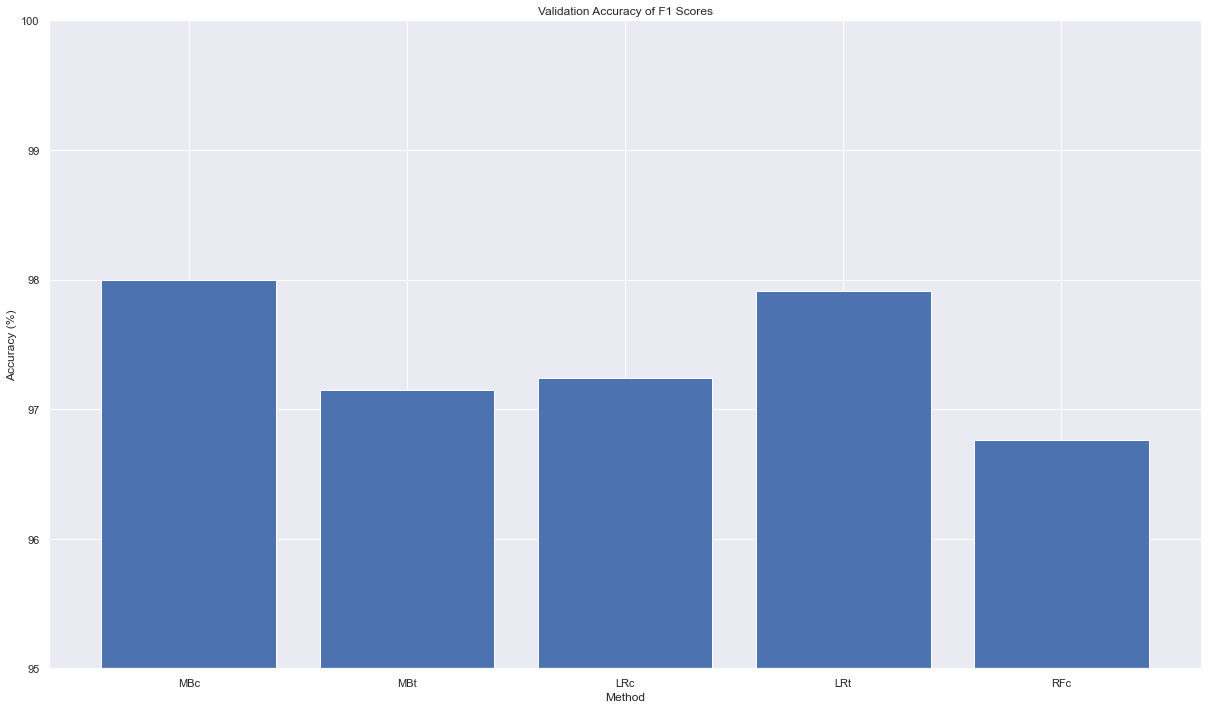

In [223]:
# barplot of accuracy of F1 scores of different models
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set(ylim=(95,100))
langs = ['MBc', 'MBt', 'LRc', 'LRt', 'RFc']
f1score = [98.0,97.15,97.24,97.91,96.76]
ax.bar(langs,f1score)
ax.set_title("Validation Accuracy of F1 Scores")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Method")
plt.show()

In [224]:
#check the test set from the beginning using multinomial naive bayes with countVectorizer whihc performed the best
MB1 = CountVectorizer().fit(X_train_clean)
MB2 = MB1.transform(X_train_clean)
MB3 = MultinomialNB(alpha=0.1)
MB3.fit(MB2,Y_train)
MB4 = MB3.predict(MB2)
MB5 = MB1.transform(X_test_clean)
MB6 = MB3.predict(MB5)

In [225]:
print(classification_report(Y_test, MB6, digits= 4))

              precision    recall  f1-score   support

           0     0.9834    0.9807    0.9820      1086
           1     0.9552    0.9614    0.9583       466

    accuracy                         0.9749      1552
   macro avg     0.9693    0.9710    0.9702      1552
weighted avg     0.9749    0.9749    0.9749      1552



Confusion matrix, without normalization


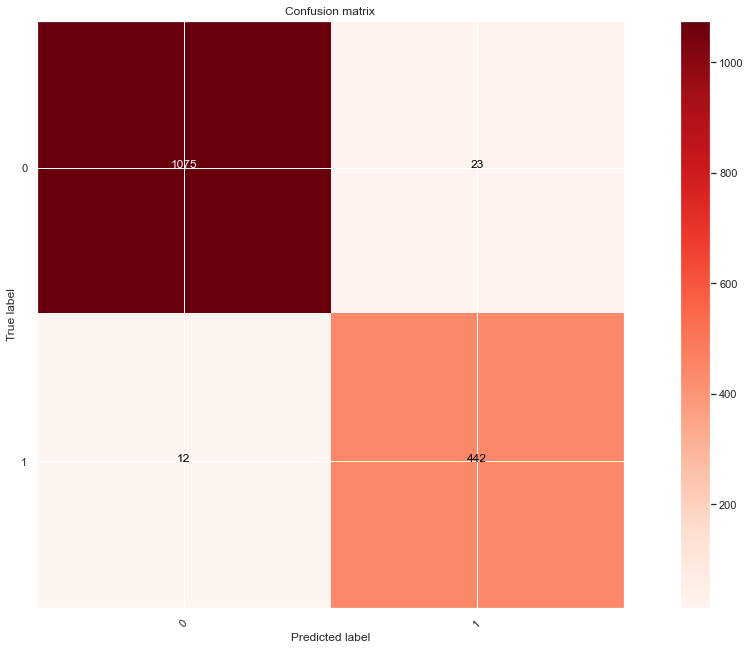

In [100]:
cm = metrics.confusion_matrix(Y_test, MB6, labels=[0,1])
plot_confusion_matrix(cm, classes = [0,1])

In [226]:
pickle.dump(MB3, open('MB_test_CountVec.sav', 'wb'))

Overall 1075 weree correctly classified as non-spam and 442 were classified correctly as spam. 
23 spam non-spam were misclassified as spam, and 12 spam were misclassified as non-spam.
The accuracy of the model was 97.74%.